In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mutual_info_score, accuracy_score
from sklearn.metrics import roc_auc_score,confusion_matrix,f1_score
from sklearn.metrics import precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

In [4]:
def load_data(path):
    data = pd.read_csv(path)
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    cat_col = data.dtypes[data.dtypes == 'object'].index.tolist()

    for col in cat_col:
        data[col] = data[col].str.lower().str.replace(' ', '_')
    return data

In [6]:
data = load_data('./weatherAUS.csv')
data.head()

,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,...,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow
145455,2017-06-21,uluru,2.8,23.4,0.0,NaN,NaN,e,31.0,se,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,no,no
145456,2017-06-22,uluru,3.6,25.3,0.0,NaN,NaN,nnw,22.0,se,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,no,no
145457,2017-06-23,uluru,5.4,26.9,0.0,NaN,NaN,n,37.0,se,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,no,no
145458,2017-06-24,uluru,7.8,27.0,0.0,NaN,NaN,se,28.0,sse,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,no,no
145459,2017-06-25,uluru,14.9,NaN,0.0,NaN,NaN,NaN,NaN,ese,...,62.0,36.0,1020.2,1017.9,8.0,8.0,15.0,20.9,no,NaN


In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           145460 non-null  object 
 1   location       145460 non-null  object 
 2   mintemp        143975 non-null  float64
 3   maxtemp        144199 non-null  float64
 4   rainfall       142199 non-null  float64
 5   evaporation    82670 non-null   float64
 6   sunshine       75625 non-null   float64
 7   windgustdir    135134 non-null  object 
 8   windgustspeed  135197 non-null  float64
 9   winddir9am     134894 non-null  object 
 10  winddir3pm     141232 non-null  object 
 11  windspeed9am   143693 non-null  float64
 12  windspeed3pm   142398 non-null  float64
 13  humidity9am    142806 non-null  float64
 14  humidity3pm    140953 non-null  float64
 15  pressure9am    130395 non-null  float64
 16  pressure3pm    130432 non-null  float64
 17  cloud9am       89572 non-null

In [61]:
df = data[data['raintomorrow'] == 'yes']
df.head()

,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,...,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow
8,2008-12-09,albury,9.7,31.9,0.0,NaN,NaN,nnw,80.0,se,...,42.0,9.0,1008.9,1003.6,NaN,NaN,18.3,30.2,no,yes
10,2008-12-11,albury,13.4,30.4,0.0,NaN,NaN,n,30.0,sse,...,48.0,22.0,1011.8,1008.7,NaN,NaN,20.4,28.8,no,yes
11,2008-12-12,albury,15.9,21.7,2.2,NaN,NaN,nne,31.0,ne,...,89.0,91.0,1010.5,1004.2,8.0,8.0,15.9,17.0,yes,yes
12,2008-12-13,albury,15.9,18.6,15.6,NaN,NaN,w,61.0,nnw,...,76.0,93.0,994.3,993.0,8.0,8.0,17.4,15.8,yes,yes
16,2008-12-17,albury,14.1,20.9,0.0,NaN,NaN,ene,22.0,ssw,...,69.0,82.0,1012.2,1010.4,8.0,1.0,17.2,18.1,no,yes


In [62]:
data.iloc[10].to_dict()

{'date': '2008-12-11',
 'location': 'albury',
 'mintemp': 13.4,
 'maxtemp': 30.4,
 'rainfall': 0.0,
 'evaporation': nan,
 'sunshine': nan,
 'windgustdir': 'n',
 'windgustspeed': 30.0,
 'winddir9am': 'sse',
 'winddir3pm': 'ese',
 'windspeed9am': 17.0,
 'windspeed3pm': 6.0,
 'humidity9am': 48.0,
 'humidity3pm': 22.0,
 'pressure9am': 1011.8,
 'pressure3pm': 1008.7,
 'cloud9am': nan,
 'cloud3pm': nan,
 'temp9am': 20.4,
 'temp3pm': 28.8,
 'raintoday': 'no',
 'raintomorrow': 'yes'}

In [53]:
#(data.isnull().sum()/data.shape[0]) *100

In [48]:
data['date'] = pd.to_datetime(data['date'])

num_col = data.dtypes[data.dtypes == 'float64'].index.tolist()
cat_col = data.dtypes[data.dtypes == 'object'].index.tolist()

for col in num_col:
        data[col] = data[col].interpolate(method='linear')
for col in num_col:
        data[col] = data[col].fillna(data[col].mean())

for col in cat_col:
        data[col] = data[col].fillna(data[col].mode()[0])

In [49]:
data.iloc[10]

date             2008-12-11 00:00:00
location                      albury
mintemp                         13.4
maxtemp                         30.4
rainfall                         0.0
evaporation                 6.534638
sunshine                    7.649576
windgustdir                        n
windgustspeed                   30.0
winddir9am                       sse
winddir3pm                       ese
windspeed9am                    17.0
windspeed3pm                     6.0
humidity9am                     48.0
humidity3pm                     22.0
pressure9am                   1011.8
pressure3pm                   1008.7
cloud9am                         6.6
cloud3pm                         8.0
temp9am                         20.4
temp3pm                         28.8
raintoday                         no
raintomorrow                     yes
Name: 10, dtype: object

<AxesSubplot: >

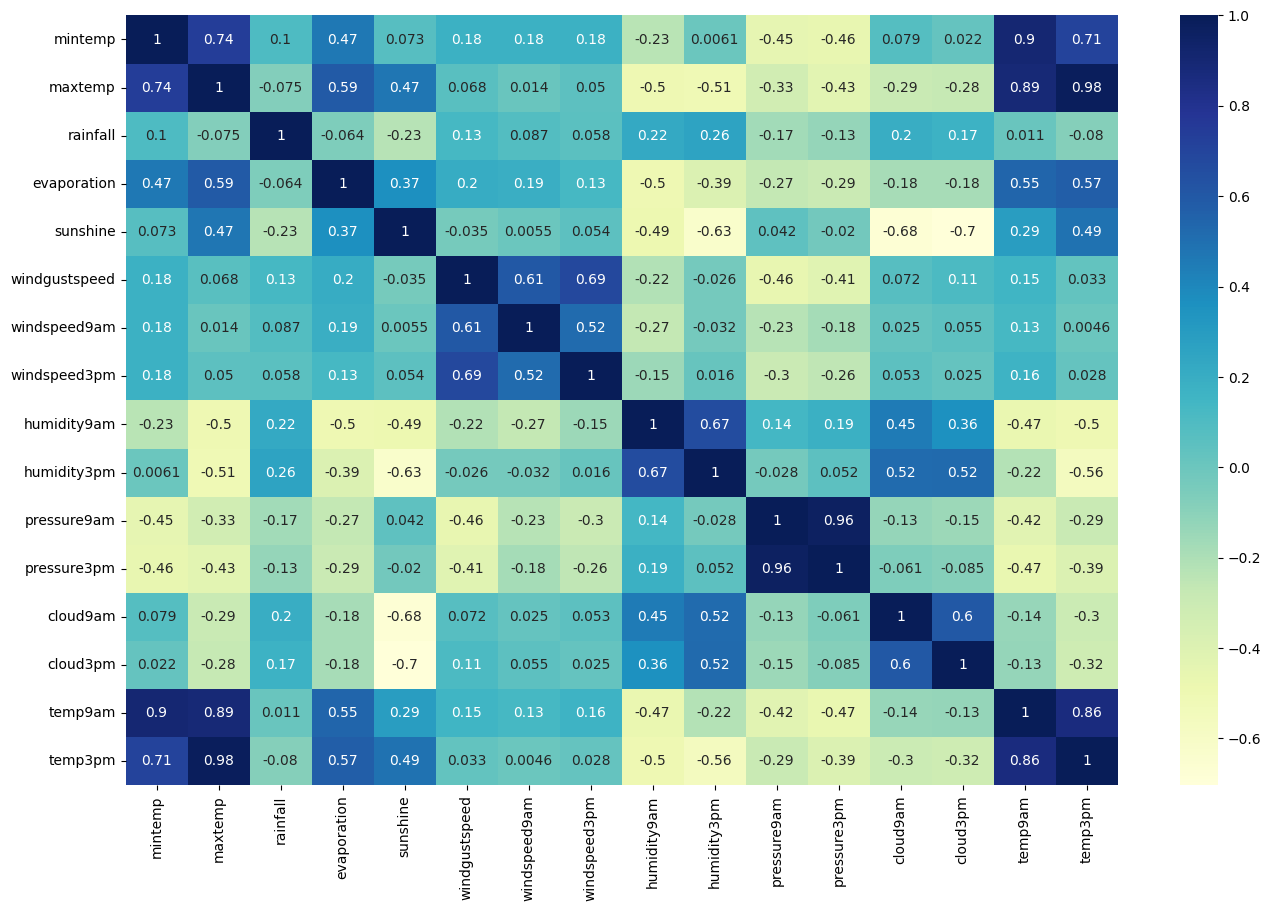

In [7]:
plt.figure(figsize =  (16,10))
sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)

In [7]:
#(data.isnull().sum()/data.shape[0]) * 100

In [8]:
# plt.figure(figsize=(16,15))
# row = int((len(num_col)/4) + 1)

# for i,col in enumerate(num_col):
#     plt.subplot(row, 4, i+1)
#     plt.hist(data[col])
#     plt.xlabel(col)

In [9]:
# plt.figure(figsize=(16,15))
# num_col2 = data.dtypes[data.dtypes == 'float64'].index.tolist()
# num_col2.remove('mintemp')
# num_col2.remove('maxtemp')
# num_col2.remove('temp3pm')
# num_col2.remove('temp9am')
# row = int((len(num_col)/4) + 1)

# for i,col in enumerate(num_col2):
#     plt.subplot(row, 4, i+1)
#     plt.hist(np.log1p(data[col]))
#     plt.xlabel(col)

In [10]:
df = data.copy()
df['evaporation'] = np.log1p(df['evaporation'])
df['rainfall'] = np.log1p(df['rainfall'])

In [11]:
def split_data(df):
        
    full_train_df, full_test_df = train_test_split(df, test_size = 0.2, random_state=1)
    full_train_df, full_val_df = train_test_split(full_train_df, test_size = 0.25, random_state=1)

    train_data = full_train_df.reset_index(drop = True)
    test_data = full_test_df.reset_index(drop = True)
    val_data = full_val_df.reset_index(drop = True)

    y_train = (train_data['raintomorrow'] == 'yes').astype('int')
    y_test = (test_data['raintomorrow'] == 'yes').astype('int')
    y_val = (val_data['raintomorrow'] == 'yes').astype('int')

    del train_data['raintomorrow']
    del test_data['raintomorrow']
    del val_data['raintomorrow']

    return train_data, val_data,test_data, y_train, y_val, y_test,full_train_df

In [12]:
full_train_df = split_data(df)[-1]

full_train = full_train_df.copy()
full_train['raintomorrow'] = (full_train['raintomorrow'] == 'yes').astype('int')

global_rate = full_train['raintomorrow'].mean()

rain_today_rate = full_train[full_train.raintoday == 'yes']['raintomorrow'].mean()
norain_today_rate = full_train[full_train.raintoday == 'no']['raintomorrow'].mean()

print(f'The global rainfall rate is {global_rate}')
print(f'The rainfall rate if it rains today is {rain_today_rate}')
print(f'The rainfall rate if it does not rain today is {norain_today_rate}')

The global rainfall rate is 0.2201407030569687
The rainfall rate if it rains today is 0.4600459002712289
The rainfall rate if it does not rain today is 0.15260483965699517


In [13]:
#Function for mutual information between features and target

num_col = full_train.dtypes[full_train.dtypes == 'float64'].index.tolist()
cat_col = full_train.dtypes[full_train.dtypes == 'object'].index.tolist()

def mutual_info(series):
    return mutual_info_score(series, full_train['raintomorrow'])

mi = full_train[cat_col].apply(mutual_info)
mi.sort_values(ascending = False)

raintoday      0.042166
location       0.012949
winddir9am     0.006459
windgustdir    0.005565
winddir3pm     0.004345
dtype: float64

In [14]:
# plt.figure(figsize= (16,10))
# row = int(len(cat_col)/4) +1

# for i,col in enumerate(cat_col):
#     plt.subplot(row,4, i+1)
#     sns.countplot(x = col, data = train_data, order = train_data[col].value_counts().sort_values(ascending = False).head(10).index)
#     plt.ylabel(col)
#     plt.xticks(rotation = 45) 

In [15]:
# data = train_data.groupby(['raintoday'])['raintomorrow'].mean().sort_values(ascending = False).head(10)
# sns.barplot(x = data.index, y = data.values)
# #plt.ylabel(col)
# plt.xticks(rotation = 45) 

In [16]:
# d = train_data.groupby(['month'])['raintomorrow'].mean()
# sns.barplot(x = d.index, y = d.values)

In [17]:
#train_data[num_col].corrwith(train_data['raintomorrow']).sort_values(ascending = False)

In [18]:
# plt.figure(figsize=(25,20))
# row = int(len(num_col)/4) + 1
# num_col.remove('date')

# for i,col in enumerate(num_col):
#     plt.subplot(row,4, i+1)
#     #data = train_data.groupby(['location'])[col].mean().sort_values(ascending = False).head(10)
#     sns.boxplot(x = 'raintomorrow', y = col, data = train_data)
#     plt.ylabel(col)
#     plt.xticks(rotation = 45)

In [19]:
# plt.figure(figsize=(25,15))
# row = int(len(num_col)/4) + 1

# for i,col in enumerate(cat_col):
#     plt.subplot(row,4, i+1)
#     data = train_data.groupby([col])['raintomorrow'].mean().sort_values(ascending = False).head(10)
#     sns.barplot(x = data.index, y = data.values)
#     plt.ylabel(col)
#     plt.xticks(rotation = 45)

In [20]:
# plt.figure(figsize =  (16,10))
# sns.heatmap(train_data.corr(), cmap="YlGnBu", annot=True)

In [21]:
def encoding(train_data, test_data, val_data):
    cat_col = train_data.dtypes[train_data.dtypes == 'object'].index.tolist()
    num_col = train_data.dtypes[train_data.dtypes == 'float64'].index.tolist()

    dv = DictVectorizer(sparse = False)
    dv.fit(train_data[cat_col + num_col].to_dict(orient = 'records'))
    feature_names = dv.get_feature_names()

    X_train = dv.transform(train_data[cat_col + num_col].to_dict(orient = 'records'))
    X_test = dv.transform(test_data[cat_col + num_col].to_dict(orient = 'records'))
    X_val = dv.transform(val_data[cat_col + num_col].to_dict(orient = 'records'))

    return X_train,X_test, X_val

In [22]:
def xg_boost(x_train,y_train,x_val,y_val):

    dtrain = xgb.DMatrix(x_train, label = y_train)
    dval = xgb.DMatrix(x_val, label = y_val)

    x_params = {
    'eta': 0.3,
    'max_depth':6,
    'min_child_weight':1,

    'objective':'binary:logistic',
    'n_threads':5,

    'seed':1,
    'verbosity':0
    }

    model = xgb.train(x_params, dtrain = dtrain,num_boost_round = 10)

    pred = model.predict(dval)
    auc = roc_auc_score(y_val,pred)

    out = (pred >= 0.5).astype('int')
    acc =  accuracy_score(y_val, out)
    precision = precision_score(y_val,out)
    recall = recall_score(y_val, out)
    f1 = f1_score(y_val, out)

    return ['xgb', acc, auc, precision,recall,f1]

In [23]:
def base_training(x_train, y_train,x_val, y_val):
    
    models = [LogisticRegression(), 
                DecisionTreeClassifier(max_depth = 7, min_samples_leaf = 5),
                RandomForestClassifier(n_estimators = 10, max_depth = 10, min_samples_split = 7, min_samples_leaf = 5)]

    scores = []
    names = ['LogisticRegression', 'DecisionTree', 'RandomForest']
    for i,model in enumerate(models):
        model.fit(x_train, y_train)
        prediction = model.predict(x_val)
        acc = accuracy_score(y_val, prediction)
        auc = roc_auc_score(y_val, prediction)
        precision = precision_score(y_val, prediction)
        recall = recall_score(y_val, prediction)
        f1 = f1_score(y_val, prediction)

        
        scores.append([names[i], acc,auc, precision, recall, f1])
     
    scores.append(xg_boost(X_train, y_train, X_val,y_val))
    output = pd.DataFrame(scores, columns = ['model','accuracy_score', 'auc_score','precision_score', 'recall_score', 'f1_score'])
    return output

In [24]:
train_data, val_data,test_data, y_train, y_val, y_test = split_data(df)[0:6]
X_train,X_test, X_val = encoding(train_data, test_data, val_data)
#base_training(X_train, y_train, X_val, y_val)

In [25]:
#feature engineering
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['monthly_bins'] = pd.cut(x = df['month'], bins = [0, 3, 6, 9, 12], labels = ['0 - 3', '3 - 6', '6 - 9', '9 - 12'])
df['temp_diff'] = df['maxtemp'] - df['mintemp']

train_data, val_data,test_data, y_train, y_val, y_test = split_data(df)[0:6]
X_train,X_test, X_val = encoding(train_data, test_data, val_data)
#base_training(X_train, y_train, X_val, y_val)

In [26]:
# plt.figure(figsize =  (16,10))
# sns.heatmap(train_data.corr(), cmap="YlGnBu", annot=True)

In [27]:
df.drop(['mintemp', 'date', 'temp3pm','temp_diff', 'maxtemp', 'day'], axis = 1, inplace = True)
train_data, val_data,test_data, y_train, y_val, y_test = split_data(df)[0:6]
X_train,X_test, X_val = encoding(train_data, test_data, val_data)
#base_training(X_train, y_train, X_val, y_val)

In [28]:
train_data, val_data,test_data, y_train, y_val, y_test = split_data(df)[0:6]
cat_col = train_data.dtypes[train_data.dtypes == 'object'].index.tolist()
num_col = train_data.dtypes[train_data.dtypes == 'float64'].index.tolist()
 

scaler = StandardScaler()
train_dat = scaler.fit_transform(train_data[num_col])
val_dat = scaler.transform(val_data[num_col])
test_dat = scaler.transform(test_data[num_col])

#base_training(train_dat, y_train, val_dat, y_val)

In [29]:
# plt.figure(figsize =  (16,10))
# sns.heatmap(train_df.corr(), cmap="YlGnBu", annot=True)

In [30]:
train_df = pd.DataFrame(train_dat, columns = num_col)
val_df = pd.DataFrame(val_dat, columns = num_col)
test_df = pd.DataFrame(test_dat, columns = num_col)

train_df = pd.concat([train_df, train_data[cat_col]], axis = 1)
val_df = pd.concat([val_df, val_data[cat_col]], axis = 1)
test_df = pd.concat([test_df, test_data[cat_col]], axis = 1)

train_df.drop(['pressure9am'], axis = 1, inplace = True)
val_df.drop(['pressure9am'], axis = 1, inplace = True)
test_df.drop(['pressure9am'], axis = 1, inplace = True)

X_train,X_test, X_val = encoding(train_df, test_df, val_df)
base_training(X_train, y_train, X_val, y_val)

,model,accuracy_score,auc_score,precision_score,recall_score,f1_score
0,LogisticRegression,0.848240,0.720073,0.724306,0.492523,0.586339
1,DecisionTree,0.841056,0.690807,0.736267,0.424052,0.538154
2,RandomForest,0.835728,0.663635,0.764449,0.358099,0.487726
3,xgb,0.848584,0.864443,0.736523,0.477412,0.579314


In [31]:
undersample = RandomUnderSampler(sampling_strategy=0.3)

y = y_train.copy()
X_train, y = undersample.fit_resample(X_train, y)

base_training(X_train, y, X_val, y_val)

,model,accuracy_score,auc_score,precision_score,recall_score,f1_score
0,LogisticRegression,0.848137,0.724601,0.715719,0.505273,0.592360
1,DecisionTree,0.840472,0.707050,0.700845,0.470172,0.562789
2,RandomForest,0.836519,0.667657,0.759506,0.367858,0.495652
3,xgb,0.848068,0.864770,0.727894,0.485912,0.582783


In [32]:
oversample = SMOTE()
X_train,X_test, X_val = encoding(train_df, test_df, val_df)
y = y_train.copy()
X_train, y = oversample.fit_resample(X_train, y)

base_training(X_train, y, X_val, y_val)

,model,accuracy_score,auc_score,precision_score,recall_score,f1_score
0,LogisticRegression,0.789633,0.780755,0.512280,0.764993,0.613636
1,DecisionTree,0.790664,0.744323,0.516137,0.662049,0.580058
2,RandomForest,0.797436,0.757730,0.527805,0.687234,0.597060
3,xgb,0.811701,0.855460,0.556054,0.683142,0.613081


In [33]:
dtrain = xgb.DMatrix(X_train, label = y)
dval = xgb.DMatrix(X_val, label = y_val)


scores = []
eta = [0.1,0.3,0.5,0.7,0.9]
for i in eta:
    x_params = {
    'eta': i,
    'max_depth':6,
    'min_child_weight':1,

    'objective':'binary:logistic',
    'n_threads':5,

    'seed':1,
    'verbosity':0
    }

    model = xgb.train(x_params, dtrain = dtrain,num_boost_round = 10)

    pred = model.predict(dval)
    #auc = roc_auc_score(y_val,pred)

    out = (pred >= 0.5).astype('int')
    #acc =  accuracy_score(y_val, out)
    precision = precision_score(y_val,out)
    recall = recall_score(y_val, out)
    f1 = f1_score(y_val, out)
    scores.append([i, precision,recall,f1])

out = pd.DataFrame(scores, columns = ['eta','precision_score', 'recall_score', 'f1_score'])

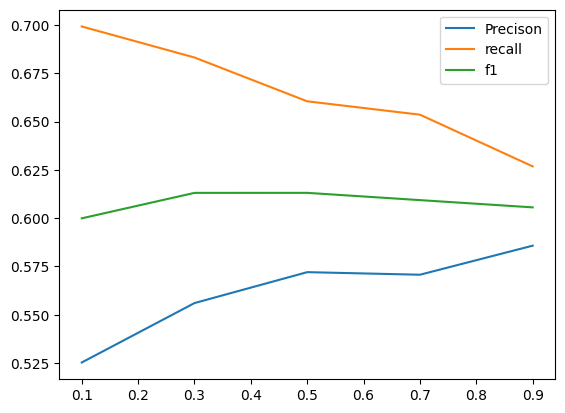

In [34]:
plt.plot(out['eta'], out['precision_score'], label = 'Precison')
plt.plot(out['eta'], out['recall_score'], label = 'recall')
plt.plot(out['eta'], out['f1_score'], label = 'f1')

plt.legend()

In [35]:
scores = []
round = np.arange(10, 200, 10)

for i in round:
    x_params = {
    'eta': 0.3,
    'max_depth':6,
    'min_child_weight':1,

    'objective':'binary:logistic',
    'n_threads':5,

    'seed':1,
    'verbosity':0
    }

    model = xgb.train(x_params, dtrain = dtrain,num_boost_round = i)

    pred = model.predict(dval)
    #auc = roc_auc_score(y_val,pred)

    out = (pred >= 0.5).astype('int')
    #acc =  accuracy_score(y_val, out)
    precision = precision_score(y_val,out)
    recall = recall_score(y_val, out)
    f1 = f1_score(y_val, out)
    scores.append([i, precision,recall,f1])

out = pd.DataFrame(scores, columns = ['boost_round','precision_score', 'recall_score', 'f1_score'])

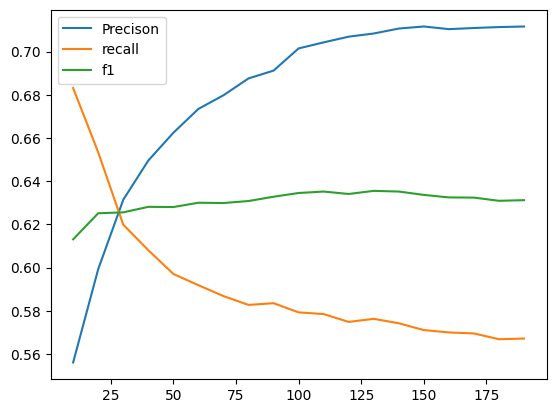

In [36]:
plt.plot(out['boost_round'], out['precision_score'], label = 'Precison')
plt.plot(out['boost_round'], out['recall_score'], label = 'recall')
plt.plot(out['boost_round'], out['f1_score'], label = 'f1')

plt.legend()

In [37]:
%%capture table
watchlist = [(dtrain,'train'), (dval, 'validation')]

x_params = {
    'eta': 0.3,
    'max_depth':6,
    'min_child_weight':1,

    'objective':'binary:logistic',
    'eval_metric' : 'aucpr',
    
    'n_threads':8,
    'seed':1,
    'verbosity':0
}

model = xgb.train(x_params, dtrain = dtrain,evals = watchlist, verbose_eval = 5,num_boost_round = 200)

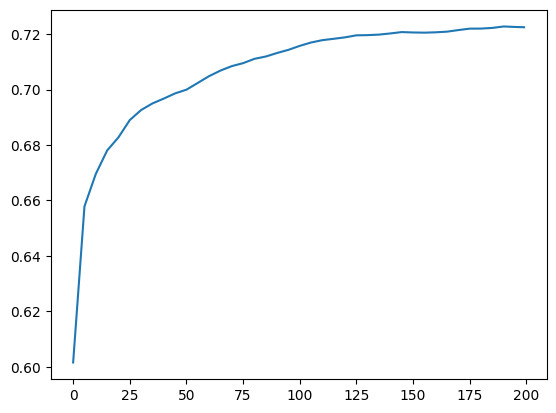

In [38]:
def parse_xgb_output():

    no_itrs = []
    train_score = []
    val_score = []

    for i in table.stdout.strip().split('\n'):

        no_itr, train_auc, val_auc = i.split('\t')

        no_itr = int(no_itr.strip('[]'))
        train_auc = float(train_auc.split(':')[1])
        val_auc = float(val_auc.split(':')[1])

        no_itrs.append(no_itr)
        train_score.append(train_auc)
        val_score.append(val_auc)

    dicts = {'iter':no_itrs, 'train_score':train_score, 'val_score':val_score}
    output = pd.DataFrame(dicts)
    return output

output = parse_xgb_output()
    
plt.plot(output.iter, output.val_score)

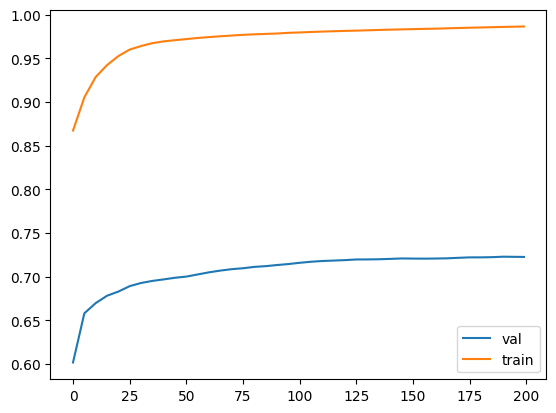

In [39]:
plt.plot(output.iter, output.val_score, label = 'val')
plt.plot(output.iter, output.train_score, label = 'train')

plt.legend()

In [40]:
%%capture table
watchlist = [(dtrain,'train'), (dval, 'validation')]

x_params = {
    'eta': 0.3,
    'max_depth':6,
    'min_child_weight':1,

    'objective':'binary:logistic',
    'eval_metric' : 'map',
    
    'n_threads':8,
    'seed':1,
    'verbosity':0
}

model = xgb.train(x_params, dtrain = dtrain,evals = watchlist, verbose_eval = 5,num_boost_round = 200)

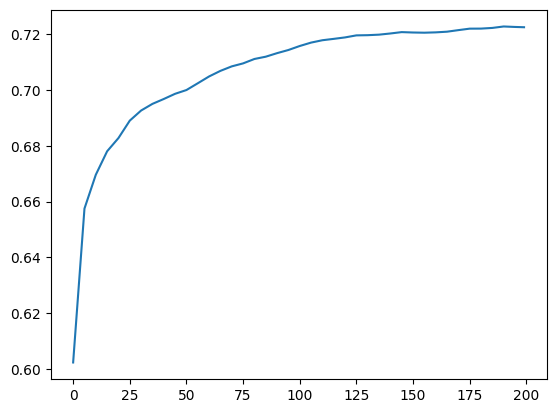

In [41]:
def parse_xgb_output():

    no_itrs = []
    train_score = []
    val_score = []

    for i in table.stdout.strip().split('\n'):

        no_itr, train_auc, val_auc = i.split('\t')

        no_itr = int(no_itr.strip('[]'))
        train_auc = float(train_auc.split(':')[1])
        val_auc = float(val_auc.split(':')[1])

        no_itrs.append(no_itr)
        train_score.append(train_auc)
        val_score.append(val_auc)

    dicts = {'iter':no_itrs, 'train_score':train_score, 'val_score':val_score}
    output = pd.DataFrame(dicts)
    return output

output = parse_xgb_output()
    
plt.plot(output.iter, output.val_score)

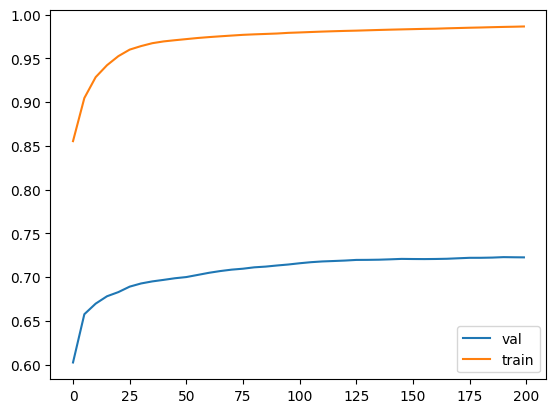

In [42]:
plt.plot(output.iter, output.val_score, label = 'val')
plt.plot(output.iter, output.train_score, label = 'train')

plt.legend()

In [43]:
x_params = {
    'eta': 0.3,
    'max_depth':6,
    'min_child_weight':1,

    'objective':'binary:logistic',
    'eval_metric' : 'map',
    
    'n_threads':8,
    'seed':1,
    'verbosity':0
}

model = xgb.train(x_params, dtrain = dtrain,num_boost_round = 25)

In [44]:
pred = model.predict(dval)
out = (pred >= 0.5).astype('int')
#acc =  accuracy_score(y_val, out)
precision = precision_score(y_val,out)
recall = recall_score(y_val, out)
f1 = f1_score(y_val, out)

print(precision, recall, f1)

0.618131445282438 0.6321422949787502 0.6250583657587547


In [31]:
def encoding(train_data, test_data):
    cat_col = train_data.dtypes[train_data.dtypes == 'object'].index.tolist()
    num_col = train_data.dtypes[train_data.dtypes == 'float64'].index.tolist()

    dv = DictVectorizer(sparse = False)
    dv.fit(train_data[cat_col + num_col].to_dict(orient = 'records'))
    feature_names = dv.get_feature_names()

    X_train = dv.transform(train_data[cat_col + num_col].to_dict(orient = 'records'))
    X_test = dv.transform(test_data[cat_col + num_col].to_dict(orient = 'records'))

    return X_train,X_test

In [39]:
train_data, val_data,test_data, y_train, y_val, y_test = split_data(df)[0:6]
cat_col = train_data.dtypes[train_data.dtypes == 'object'].index.tolist()
num_col = train_data.dtypes[train_data.dtypes == 'float64'].index.tolist()
 

scaler = StandardScaler()
train_dat = scaler.fit_transform(train_data[num_col])
test_dat = scaler.transform(test_data[num_col])
val_dat = scaler.transform(val_data[num_col])

In [40]:
train_df = pd.DataFrame(train_dat, columns = num_col)
val_df = pd.DataFrame(val_dat, columns = num_col)
test_df = pd.DataFrame(test_dat, columns = num_col)

train_df = pd.concat([train_df, train_data[cat_col]], axis = 1)
val_df = pd.concat([val_df, val_data[cat_col]], axis = 1)
test_df = pd.concat([test_df, test_data[cat_col]], axis = 1)

train_df.drop(['pressure9am'], axis = 1, inplace = True)
val_df.drop(['pressure9am'], axis = 1, inplace = True)
test_df.drop(['pressure9am'], axis = 1, inplace = True)

full_train_data = pd.concat([train_df, val_df])
full_y_train = pd.concat([y_train, y_val])

In [41]:
oversample = SMOTE()
X_train,X_test = encoding(full_train_data, test_df)
y = full_y_train.copy()
X_train, y = oversample.fit_resample(X_train, y)

In [42]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

x_params = {
    'eta': 0.3,
    'max_depth':6,
    'min_child_weight':1,

    'objective':'binary:logistic',
    'eval_metric' : 'map',
    
    'n_threads':8,
    'seed':1,
    'verbosity':0
}

model = xgb.train(x_params, dtrain = dtrain,num_boost_round = 25)

In [101]:
pred = model.predict(dtest)
out = (pred >= 0.5).astype('int')
precision = precision_score(y_test,out)
recall = recall_score(y_test, out)
f1 = f1_score(y_test, out)

print(precision, recall, f1)

0.6006532066508313 0.6411028363175408 0.620219207480647


In [102]:
#Loading Data
def load_data(path):
    data = pd.read_csv(path)
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    cat_col = data.dtypes[data.dtypes == 'object'].index.tolist()

    for col in cat_col:
        data[col] = data[col].str.lower().str.replace(' ', '_')
    return data

#Spliting Data
def split_data(df):
        
    full_train_df, full_test_df = train_test_split(df, test_size = 0.2, random_state=1)
    full_train_df, full_val_df = train_test_split(full_train_df, test_size = 0.25, random_state=1)

    train_data = full_train_df.reset_index(drop = True)
    test_data = full_test_df.reset_index(drop = True)
    val_data = full_val_df.reset_index(drop = True)

    y_train = (train_data['raintomorrow'] == 'yes').astype('int')
    y_test = (test_data['raintomorrow'] == 'yes').astype('int')
    y_val = (val_data['raintomorrow'] == 'yes').astype('int')

    del train_data['raintomorrow']
    del test_data['raintomorrow']
    del val_data['raintomorrow']

    return train_data, val_data,test_data, y_train, y_val, y_test,full_train_df

#Encoding Data
def encoding(train_data, test_data):
    cat_col = train_data.dtypes[train_data.dtypes == 'object'].index.tolist()
    num_col = train_data.dtypes[train_data.dtypes == 'float64'].index.tolist()

    dv = DictVectorizer(sparse = False)
    dv.fit(train_data[cat_col + num_col].to_dict(orient = 'records'))
    feature_names = dv.get_feature_names()

    X_train = dv.transform(train_data[cat_col + num_col].to_dict(orient = 'records'))
    X_test = dv.transform(test_data[cat_col + num_col].to_dict(orient = 'records'))

    return X_train,X_test

#Defining xgboost model
def xg_boost(x_train,y_train,x_test, y_test):

    dtrain = xgb.DMatrix(x_train, label = y_train)
    dtest = xgb.DMatrix(x_test)

    x_params = {
    'eta': 0.3,
    'max_depth':6,
    'min_child_weight':1,

    'objective':'binary:logistic',
    'eval_metric' : 'map',
    
    'n_threads':8,
    'seed':1,
    'verbosity':0
    }

    model = xgb.train(x_params, dtrain = dtrain,num_boost_round = 25)

    pred = model.predict(dtest)
    out = (pred >= 0.5).astype('int')
    precision = precision_score(y_test,out)
    recall = recall_score(y_test, out)
    f1 = f1_score(y_test, out)

    return (precision,recall,f1)

#Data Preparation
def data_prep(df):

    #filling missing values
    df['date'] = pd.to_datetime(df['date'])

    num_col = df.dtypes[df.dtypes == 'float64'].index.tolist()
    cat_col = df.dtypes[df.dtypes == 'object'].index.tolist()

    for col in num_col:
            df[col] = df[col].interpolate(method='linear')
    for col in num_col:
            df[col] = df[col].fillna(df[col].mean())

    for col in cat_col:
            df[col] = df[col].fillna(df[col].mode()[0])

    #feature engineering
    df['year'] = pd.DatetimeIndex(df['date']).year
    df['month'] = pd.DatetimeIndex(df['date']).month
    df['day'] = pd.DatetimeIndex(df['date']).day
    df['monthly_bins'] = pd.cut(x = df['month'], bins = [0, 3, 6, 9, 12], labels = ['0 - 3', '3 - 6', '6 - 9', '9 - 12'])
    df['temp_diff'] = df['maxtemp'] - df['mintemp']
    df.drop(['mintemp', 'date', 'temp3pm','temp_diff', 'maxtemp', 'day'], axis = 1, inplace = True) #Dropping columns

    # #feature transformation
    df['evaporation'] = np.log1p(df['evaporation']) #log transformation
    df['rainfall'] = np.log1p(df['rainfall']) #log transformation

    #Transformaing numerical features
    train_data, val_data,test_data, y_train, y_val, y_test = split_data(df)[0:6]
    cat_col = train_data.dtypes[train_data.dtypes == 'object'].index.tolist()
    num_col = train_data.dtypes[train_data.dtypes == 'float64'].index.tolist()
    
    scaler = StandardScaler()
    transformed_xtrain = scaler.fit_transform(train_data[num_col])
    transformed_xtest = scaler.transform(test_data[num_col])
    transformed_xval  = scaler.transform(val_data[num_col])

    train_df = pd.DataFrame(transformed_xtrain, columns = num_col)
    val_df = pd.DataFrame(transformed_xval, columns = num_col)
    test_df = pd.DataFrame(transformed_xtest, columns = num_col)

    train_df = pd.concat([train_df, train_data[cat_col]], axis = 1)
    val_df = pd.concat([val_df, val_data[cat_col]], axis = 1)
    test_df = pd.concat([test_df, test_data[cat_col]], axis = 1)

    train_df.drop(['pressure9am'], axis = 1, inplace = True)
    val_df.drop(['pressure9am'], axis = 1, inplace = True)
    test_df.drop(['pressure9am'], axis = 1, inplace = True)

    full_train_data = pd.concat([train_df, val_df])
    full_y_train = pd.concat([y_train, y_val])

    return full_train_data,full_y_train, test_df, y_test

#oversampling data
def data_augm(xtrain, ytrain):
        
    oversample = SMOTE()
    X_train, ytrain = oversample.fit_resample(xtrain, ytrain)
    return X_train, ytrain



data = load_data('./weatherAUS.csv')  #loading data
train_data,y_train, test_data, y_test = data_prep(data) #data preparation
X_train,X_test = encoding(train_data, test_data) #data encoding
X_train, y_train = data_augm(X_train, y_train) #data augmentation


precision, recall, f1score = xg_boost(X_train,y_train,X_test, y_test)
print(precision, recall, f1score)

0.606087869245764 0.6404690223419427 0.622804314329738


In [ ]:
# data = pd.read_csv("C:/Users/Godwin/Downloads/FoodBalanceSheets_E_Africa_NOFLAG.csv", encoding = 'latin-1')

# data.Area.unique()

# df = data.groupby('Element')['Y2017'].sum()
# df

# data.isnull().sum()

# (data.isnull().sum()/data.shape[0])*100

# data.corr()

# my_tuppy = (1,2,5,8)

# my_tuppy[2] = 6

# data.groupby('Item')

# y = [(2, 4), (7, 8), (1, 5, 9)]
# print(y[1][1])

# data['Y2017'].mean()
# data['Y2017'].std()
# df = data[['Area', 'Y2017']]
# filter = df.index.isin(['Cabo Verde', 'Seychelles', 'Ghana', 'Comoros', 'Guinea-Bissau'])
# df.groupby('Area')['Y2017'].sum().sort_values(ascending = True).tail(7)#.where(filter, inplace = True)
# data.head()